# Hybrid WENO-PINN for 1D Burgers’ Equation

This project demonstrates a **Hybrid WENO-PINN** approach for solving the one-dimensional viscous Burgers’ equation:

$$
u_t + u\,u_x = \nu\,u_{xx}, \quad x \in [-1,1],\ t \in [0,1]
$$

## Basic Idea

- **PINN (Physics-Informed Neural Network):**  
  A neural network $u_\theta(x,t)$ is trained to satisfy the PDE residual:

  $$
  r(x,t) = \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} - \nu \frac{\partial^2 u}{\partial x^2} = 0, \quad x \in [-1,1],\ t \in [0,1]
  $$

  The network also satisfies the initial and boundary conditions. All derivatives are computed using automatic differentiation (AD).  
  PINNs are especially effective in smooth regions because AD is very accurate when $u(x,t)$ varies smoothly.

- **WENO-Z5 (Weighted Essentially Non-Oscillatory, 5th order):**  
  A classical finite-difference scheme that reconstructs spatial derivatives using a 5-point stencil. WENO-Z5 is designed to handle steep gradients or shocks without introducing oscillations (like the Gibbs phenomenon). It uses smoothness indicators to adaptively choose stencils.

- **Why Hybridize?**  
  Burgers’ equation often develops steep gradients (viscous shocks), even for small viscosity $\nu$. A pure PINN tends to smooth out these features, while WENO-Z5 can capture them sharply. The hybrid method combines both:

  1. In **smooth regions** (where $|u_x|$ is small): use PINN with AD.  
  2. **Near shocks** (where $|u_x| > \varepsilon$): switch to WENO-Z5 on a local stencil to compute $\partial_x(\frac{1}{2}u^2)$.

  This combines the flexibility of PINNs with the shock-resolving power of WENO-Z5.

## Workflow Overview

1. **Network Architecture:**  
   A feed-forward neural network $u_\theta(x,t)$ with 4 hidden layers × 64 neurons.

2. **PDE Residual Calculation:**

   - Use AD to compute $u_t$, $u_x$, and $u_{xx}$ at collocation points.
   - If $|u_x|$ at a point is small, use AD.
   - Otherwise:
     1. Take a 5-point stencil around that $x_i$:

        $$
        \{ x_{j-2},\ x_{j-1},\ x_j,\ x_{j+1},\ x_{j+2} \}
        $$

     2. Evaluate $u$ at those 5 spatial points (all at time $t_i$) and apply WENO-Z5.

3. **Loss Function:**  
   Combine mean-squared error from:

   - $ \text{MSE}_{\text{PDE}} $ — PDE residual  
   - $ \text{MSE}_{\text{IC}} $ — Initial condition  
   - $ \text{MSE}_{\text{BC}} $ — Boundary condition

4. **Training Loop:**
   - Sample collocation points $(x,t)$
   - Minimize total loss using Adam (optionally LBFGS)
   - Track how many points triggered WENO vs. AD

5. **Result:**  
   The trained network produces a sharp shock profile at $t = 1$ that closely matches the analytical or high-resolution numerical solution, without spurious oscillations.

## Why It’s Useful

- **Sharp Shock Capturing:**  
  Pure PINNs blur shocks. This hybrid preserves sharp transitions.

- **Efficient Mesh-Free Learning:**  
  PINNs don’t require structured meshes. WENO is applied only where needed, not globally.

- **Adaptive Derivative Evaluation:**  
  Based on $|u_x|$, the method switches between AD and WENO.

---

In summary, this Hybrid WENO-PINN method combines high-order, non-oscillatory finite differences with PINN’s flexibility in smooth regions, making it ideal for solving PDEs like Burgers’ equation that exhibit both smooth and sharply varying behavior.


In [1]:
# ─────────────────────────────────────────────────────────────────────────────
# pinn_traffic.py
#
# Solve the 1D traffic‐flow equation
#   ρ_t + (ρ (1−ρ))_x = 0
# on x∈[0,1], t∈[0,1], with Riemann initial condition:
#   ρ(x,0) = 1 for x < 0.5,  0 for x > 0.5.
#
# This uses a standard PINN (no WENO), and reports:
#   - PDE loss (residual)
#   - IC loss
#   - BC loss
#   - Relative L2 error at t=1 (compared to exact shock solution)
#
# To run:
#   python pinn_traffic.py
#
# Requires: torch, numpy
# ─────────────────────────────────────────────────────────────────────────────

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# ─────────────────────────────────────────────────────────────────────────────
#  Device setup
# ─────────────────────────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    torch.cuda.current_device()
    torch.cuda.synchronize()

# ─────────────────────────────────────────────────────────────────────────────
#  1) Define the PINN network: u_theta(x,t) → scalar (ρ)
# ─────────────────────────────────────────────────────────────────────────────
class PINN1D(nn.Module):
    def __init__(self, layers):
        """
        layers:  list of integers, e.g. [2, 64, 64, 64, 1]
                means: input dimension 2 → 64 neurons → 64 → 64 → 1 output
        """
        super(PINN1D, self).__init__()
        net_layers = []
        for i in range(len(layers) - 2):
            net_layers.append(nn.Linear(layers[i], layers[i + 1]))
            net_layers.append(nn.Tanh())
        # final layer (no activation)
        net_layers.append(nn.Linear(layers[-2], layers[-1]))
        self.net = nn.Sequential(*net_layers)

    def forward(self, x, t):
        # x, t are each shape (Batch,) as 1D tensors
        X = torch.stack([x, t], dim=1)  # → (Batch, 2)
        return self.net(X)              # → (Batch, 1)


# ─────────────────────────────────────────────────────────────────────────────
#  2) Flux function: f(u) = u * (1 - u)
# ─────────────────────────────────────────────────────────────────────────────
def flux(u):
    return u * (1.0 - u)


# ─────────────────────────────────────────────────────────────────────────────
#  3) Training loop for standard PINN
# ─────────────────────────────────────────────────────────────────────────────
def train_standard_pinn():
    # Hyperparameters
    Nt = 10000      # total training epochs
    N_f = 2000      # collocation points per epoch
    N_ic = 200      # initial‐condition points
    N_bc = 200      # boundary‐condition points
    lr = 1e-3       # learning rate

    # Build uniform spatial grid for evaluating error at t=1
    Nx = 101
    x_grid = torch.linspace(0.0, 1.0, Nx, device=device)  # (Nx,)
    
    # Instantiate PINN
    layers = [2, 64, 64, 64, 64, 1]
    model = PINN1D(layers).to(device)

    # Optimizer and scheduler
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

    # Prepare IC data: x_ic ∈ [0,1], t_ic = 0, ρ_ic = 1 if x<0.5 else 0
    x_ic = torch.rand(N_ic, device=device).view(-1, 1)          # (N_ic,1)
    t_ic = torch.zeros_like(x_ic)                              # (N_ic,1)
    rho_ic = torch.where(x_ic < 0.5, torch.ones_like(x_ic), torch.zeros_like(x_ic))  # (N_ic,1)

    # Prepare BC data: boundaries x=0 and x=1, random t ∈ [0,1]
    t_bc = torch.rand(N_bc, device=device).view(-1, 1)         # (N_bc,1)
    x_bc_left  = torch.zeros_like(t_bc)                        # x=0
    x_bc_right = torch.ones_like(t_bc)                         # x=1
    rho_bc_left  = torch.ones_like(t_bc)                       # ρ(0,t)=1
    rho_bc_right = torch.zeros_like(t_bc)                      # ρ(1,t)=0

    # Training loop
    for epoch in range(1, Nt + 1):
        # 1) Sample collocation points (interior) randomly in [0,1]×[0,1]
        x_f = torch.rand(N_f, 1, device=device)  # (N_f,1)
        t_f = torch.rand(N_f, 1, device=device)  # (N_f,1)

        # Enable gradients for collocation inputs
        x_f_req = x_f.clone().detach().requires_grad_(True)  # (N_f,1)
        t_f_req = t_f.clone().detach().requires_grad_(True)  # (N_f,1)

        # 2) Forward pass: predict u at collocation points
        u_pred = model(x_f_req.view(-1), t_f_req.view(-1)).view(N_f)  # (N_f,)

        # 3) Compute u_t via autograd
        grad_outputs = torch.ones_like(u_pred)
        u_t = torch.autograd.grad(
            outputs=u_pred,
            inputs=t_f_req,
            grad_outputs=grad_outputs,
            create_graph=True
        )[0].view(N_f)  # (N_f,)

        # 4) Compute f = flux(u) and then f_x via autograd
        f_val = flux(u_pred)  # (N_f,)
        # Need f_x = ∂(f(u))/∂x = (df/du)*(∂u/∂x). But using autograd directly:
        x_f_req.grad = None
        f_x = torch.autograd.grad(
            outputs=f_val,
            inputs=x_f_req,
            grad_outputs=torch.ones_like(f_val),
            create_graph=True
        )[0].view(N_f)  # (N_f,)

        # 5) PDE residual: r = u_t + f_x
        resid = u_t + f_x  # (N_f,)
        loss_pde = torch.mean(resid**2)

        # 6) IC loss: at t=0
        u_ic_pred = model(x_ic.view(-1), t_ic.view(-1)).view(-1, 1)  # (N_ic,1)
        loss_ic = torch.mean((u_ic_pred - rho_ic)**2)

        # 7) BC loss: at x=0 and x=1 for random t
        u_bc_left  = model(x_bc_left.view(-1),  t_bc.view(-1)).view(-1, 1)  # (N_bc,1)
        u_bc_right = model(x_bc_right.view(-1), t_bc.view(-1)).view(-1, 1)  # (N_bc,1)
        loss_bc = torch.mean((u_bc_left - rho_bc_left)**2 + (u_bc_right - rho_bc_right)**2)

        # 8) Total loss
        loss = loss_pde + loss_ic + loss_bc

        # 9) Backprop & optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # 10) Every 500 epochs, compute and print metrics
        if epoch % 500 == 0:
            # Relative L2 error at t=1 over x_grid
            with torch.no_grad():
                x_test = x_grid                         # (Nx,)
                t_test = torch.ones_like(x_test)         # t=1
                u_pred_test = model(x_test, t_test).view(-1)  # (Nx,)

                # Exact Riemann solution at t=1: shock at x=0.5
                u_exact = torch.where(x_test < 0.5,
                                      torch.ones_like(x_test),
                                      torch.zeros_like(x_test))  # (Nx,)

                error_l2 = torch.norm(u_pred_test - u_exact, p=2)
                norm_exact = torch.norm(u_exact, p=2)
                rel_l2 = (error_l2 / norm_exact).item()

            print(
                f"Epoch {epoch:5d} | "
                f"Loss_pde = {loss_pde.item():.3e} | "
                f"Loss_ic = {loss_ic.item():.3e} | "
                f"Loss_bc = {loss_bc.item():.3e} | "
                f"RelL2(t=1) = {rel_l2:.3e}"
            )

    # Save the trained model
    torch.save(model.state_dict(), "pinn_traffic1d.pth")
    print("Training finished, model saved as pinn_traffic1d.pth")
    return model, x_grid


# ─────────────────────────────────────────────────────────────────────────────
#  4) Run the training when this file is executed
# ─────────────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    trained_model, x_grid_final = train_standard_pinn()


c:\Users\nachi\anaconda3\envs\torch_env\lib\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch   500 | Loss_pde = 1.662e-02 | Loss_ic = 2.033e-02 | Loss_bc = 2.172e-02 | RelL2(t=1) = 5.472e-01
Epoch  1000 | Loss_pde = 1.018e-02 | Loss_ic = 8.957e-03 | Loss_bc = 1.807e-02 | RelL2(t=1) = 5.453e-01
Epoch  1500 | Loss_pde = 8.219e-03 | Loss_ic = 4.571e-03 | Loss_bc = 1.445e-02 | RelL2(t=1) = 5.332e-01
Epoch  2000 | Loss_pde = 8.717e-03 | Loss_ic = 4.386e-03 | Loss_bc = 1.393e-02 | RelL2(t=1) = 5.361e-01
Epoch  2500 | Loss_pde = 7.000e-03 | Loss_ic = 3.459e-03 | Loss_bc = 1.520e-02 | RelL2(t=1) = 5.426e-01
Epoch  3000 | Loss_pde = 7.096e-03 | Loss_ic = 3.765e-03 | Loss_bc = 1.490e-02 | RelL2(t=1) = 5.404e-01
Epoch  3500 | Loss_pde = 6.897e-03 | Loss_ic = 2.259e-03 | Loss_bc = 1.445e-02 | RelL2(t=1) = 5.380e-01
Epoch  4000 | Loss_pde = 8.401e-03 | Loss_ic = 1.969e-03 | Loss_bc = 1.395e-02 | RelL2(t=1) = 5.364e-01
Epoch  4500 | Loss_pde = 7.855e-03 | Loss_ic = 3.294e-03 | Loss_bc = 1.360e-02 | RelL2(t=1) = 5.381e-01
Epoch  5000 | Loss_pde = 6.819e-03 | Loss_ic = 2.077e-03 | Loss_

In [3]:
# ─────────────────────────────────────────────────────────────────────────────
# weno_pinn.py
#
# A 1D “Hybrid WENO-PINN” for the traffic-flow equation
#   ρ_t + (ρ (1−ρ))_x = 0
# on x∈[0,1], t∈[0,1], with a Riemann initial condition that forms a stationary shock at x=0.5.
#
# This version includes:
#  1) Vectorized “sensor → autograd vs. WENO” logic (no Python loop over collocation points)
#  2) eps_sensor linearly decayed from 20 → 5 over all epochs
#  3) Learning-rate scheduler (StepLR)
#  4) LBFGS optimizer warm-start for the final epochs
#  5) Mid-training uniform-grid refinement (Nx=101 → Nx=201 at epoch 5000)
#  6) Periodic printing of relative L₂ error at t=1 over x_grid
#  7) Counter tracking how many collocation points triggered WENO (i.e., “shock” region)
#
# To run:
#   python weno_pinn.py
#
# Requires:  torch, numpy
# ─────────────────────────────────────────────────────────────────────────────

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────────────────────
#  Device setup & CUDA warm-up
# ─────────────────────────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    torch.cuda.current_device()
    torch.cuda.synchronize()

# ─────────────────────────────────────────────────────────────────────────────
#  1) Define the PINN network:  u_theta(x,t) → scalar (ρ)
# ─────────────────────────────────────────────────────────────────────────────
class PINN1D(nn.Module):
    def __init__(self, layers):
        """
        layers:  list of integers, e.g. [2, 64, 64, 64, 1]
                means: input dimension 2 → 64 neurons → 64 → 64 → 1 output
        """
        super(PINN1D, self).__init__()
        net_layers = []
        for i in range(len(layers) - 2):
            net_layers.append(nn.Linear(layers[i], layers[i + 1]))
            net_layers.append(nn.Tanh())
        # final layer (no Tanh)
        net_layers.append(nn.Linear(layers[-2], layers[-1]))
        self.net = nn.Sequential(*net_layers)

    def forward(self, x, t):
        # x, t are each shape (Batch,) as 1D tensors
        # stack into a (Batch, 2) tensor
        X = torch.stack([x, t], dim=1)  # → shape (Batch, 2)
        return self.net(X)              # → shape (Batch, 1)


# ─────────────────────────────────────────────────────────────────────────────
#  2) Flux function: f(u) = u * (1 - u)
# ─────────────────────────────────────────────────────────────────────────────
def flux(u):
    """
    Scalar flux f(u) = u * (1 - u) for traffic-flow.
    u is a torch.tensor of arbitrary shape.
    """
    return u * (1.0 - u)


# ─────────────────────────────────────────────────────────────────────────────
#  3) Batched WENO5 reconstruction of ∂_x f at the center of each 5-point stencil
#     Input: u_vals_batch of shape (M, 5), dx = float
#     Output: dfdx of shape (M,)
# ─────────────────────────────────────────────────────────────────────────────
def weno5_flux_derivative_batched(u_vals_batch, dx):
    """
    Input:
      u_vals_batch:  torch.tensor of shape (M, 5),
                     each row = [u_{i−2}, u_{i−1}, u_i, u_{i+1}, u_{i+2}]
      dx:            float > 0,  the uniform spacing in x.
    Output:
      dfdx:  torch.tensor of shape (M,),  the WENO5-Z approximation of (∂_x f(u)) at each center.
    """
    # 1) Compute f = flux(u), shape = (M, 5)
    fvals = u_vals_batch * (1.0 - u_vals_batch)  # (M, 5)

    # 2) Lax-Friedrichs splitting with α = 1.0
    alpha = 1.0
    f_plus = 0.5 * (fvals + alpha * u_vals_batch)   # (M, 5)
    f_minus = 0.5 * (fvals - alpha * u_vals_batch)  # (M, 5)

    # 3) Reconstruct f⁺ at i+1/2 on each row (left-biased WENO5)
    p0 = (2.0 * f_plus[:, 0] - 7.0 * f_plus[:, 1] + 11.0 * f_plus[:, 2]) / 6.0  # (M,)
    p1 = (-1.0 * f_plus[:, 1] + 5.0 * f_plus[:, 2] + 2.0 * f_plus[:, 3]) / 6.0  # (M,)
    p2 = (2.0 * f_plus[:, 2] + 5.0 * f_plus[:, 3] - 1.0 * f_plus[:, 4]) / 6.0  # (M,)

    # 4) Smoothness indicators β₀, β₁, β₂ for each row
    eps = 1e-6
    beta0 = (13.0 / 12.0) * (f_plus[:, 0] - 2.0 * f_plus[:, 1] + f_plus[:, 2]) ** 2 \
          + (1.0 / 4.0) * (f_plus[:, 0] - 4.0 * f_plus[:, 1] + 3.0 * f_plus[:, 2]) ** 2  # (M,)
    beta1 = (13.0 / 12.0) * (f_plus[:, 1] - 2.0 * f_plus[:, 2] + f_plus[:, 3]) ** 2 \
          + (1.0 / 4.0) * (f_plus[:, 1] -     f_plus[:, 3]) ** 2                           # (M,)
    beta2 = (13.0 / 12.0) * (f_plus[:, 2] - 2.0 * f_plus[:, 3] + f_plus[:, 4]) ** 2 \
          + (1.0 / 4.0) * (3.0 * f_plus[:, 2] - 4.0 * f_plus[:, 3] + f_plus[:, 4]) ** 2   # (M,)

    # 5) Linear weights γ₀, γ₁, γ₂
    gamma0 = 1.0 / 10.0
    gamma1 = 6.0 / 10.0
    gamma2 = 3.0 / 10.0

    # WENO-Z global smoothness indicator τ₅
    tau5 = torch.abs(beta0 - beta2)  # (M,)
    p = 1.0

    # Nonlinear weights α₀, α₁, α₂
    alpha0 = gamma0 * (1.0 + (tau5 / (beta0 + eps)) ** p)  # (M,)
    alpha1 = gamma1 * (1.0 + (tau5 / (beta1 + eps)) ** p)
    alpha2 = gamma2 * (1.0 + (tau5 / (beta2 + eps)) ** p)
    alpha_sum = alpha0 + alpha1 + alpha2  # (M,)

    w0 = alpha0 / alpha_sum  # (M,)
    w1 = alpha1 / alpha_sum
    w2 = alpha2 / alpha_sum

    # Reconstructed f̂⁺ at i+1/2, for each row
    f_hat_plus = w0 * p0 + w1 * p1 + w2 * p2  # (M,)

    # 6) Reconstruct f⁻ at i−1/2 (mirror logic)
    fm = f_minus.flip(dims=[1])  # (M, 5)
    q0 = (2.0 * fm[:, 0] - 7.0 * fm[:, 1] + 11.0 * fm[:, 2]) / 6.0  # (M,)
    q1 = (-1.0 * fm[:, 1] + 5.0 * fm[:, 2] + 2.0 * fm[:, 3]) / 6.0  # (M,)
    q2 = (2.0 * fm[:, 2] + 5.0 * fm[:, 3] - 1.0 * fm[:, 4]) / 6.0   # (M,)

    beta0m = (13.0 / 12.0) * (fm[:, 0] - 2.0 * fm[:, 1] + fm[:, 2]) ** 2 \
           + (1.0 / 4.0) * (fm[:, 0] - 4.0 * fm[:, 1] + 3.0 * fm[:, 2]) ** 2  # (M,)
    beta1m = (13.0 / 12.0) * (fm[:, 1] - 2.0 * fm[:, 2] + fm[:, 3]) ** 2 \
           + (1.0 / 4.0) * (fm[:, 1] -     fm[:, 3]) ** 2                       # (M,)
    beta2m = (13.0 / 12.0) * (fm[:, 2] - 2.0 * fm[:, 3] + fm[:, 4]) ** 2 \
           + (1.0 / 4.0) * (3.0 * fm[:, 2] - 4.0 * fm[:, 3] + fm[:, 4]) ** 2  # (M,)

    taum5 = torch.abs(beta0m - beta2m)  # (M,)
    alpha0m = gamma0 * (1.0 + (taum5 / (beta0m + eps)) ** p)  # (M,)
    alpha1m = gamma1 * (1.0 + (taum5 / (beta1m + eps)) ** p)
    alpha2m = gamma2 * (1.0 + (taum5 / (beta2m + eps)) ** p)
    alpha_sum_m = alpha0m + alpha1m + alpha2m  # (M,)

    wm0 = alpha0m / alpha_sum_m  # (M,)
    wm1 = alpha1m / alpha_sum_m
    wm2 = alpha2m / alpha_sum_m

    f_hat_minus = wm0 * q0 + wm1 * q1 + wm2 * q2  # (M,)

    # 7) Numerical flux at i+1/2: F_{i+1/2} = f̂⁺ + f̂⁻  → shape = (M,)
    F_half = f_hat_plus + f_hat_minus  # (M,)

    # 8) Reconstruct F_{i−1/2} by performing WENO on the reversed stencil
    u_rev = u_vals_batch.flip(dims=[1])  # (M, 5)
    fvals_r = u_rev * (1.0 - u_rev)
    fpr = 0.5 * (fvals_r + alpha * u_rev)  # (M, 5)
    fmr = 0.5 * (fvals_r - alpha * u_rev)  # (M, 5)

    p0r = (2.0 * fpr[:, 0] - 7.0 * fpr[:, 1] + 11.0 * fpr[:, 2]) / 6.0  # (M,)
    p1r = (-1.0 * fpr[:, 1] + 5.0 * fpr[:, 2] + 2.0 * fpr[:, 3]) / 6.0  # (M,)
    p2r = (2.0 * fpr[:, 2] + 5.0 * fpr[:, 3] - 1.0 * fpr[:, 4]) / 6.0  # (M,)

    beta0r = (13.0 / 12.0) * (fpr[:, 0] - 2.0 * fpr[:, 1] + fpr[:, 2]) ** 2 \
           + (1.0 / 4.0) * (fpr[:, 0] - 4.0 * fpr[:, 1] + 3.0 * fpr[:, 2]) ** 2  # (M,)
    beta1r = (13.0 / 12.0) * (fpr[:, 1] - 2.0 * fpr[:, 2] + fpr[:, 3]) ** 2 \
           + (1.0 / 4.0) * (fpr[:, 1] -     fpr[:, 3]) ** 2                       # (M,)
    beta2r = (13.0 / 12.0) * (fpr[:, 2] - 2.0 * fpr[:, 3] + fpr[:, 4]) ** 2 \
           + (1.0 / 4.0) * (3.0 * fpr[:, 2] - 4.0 * fpr[:, 3] + fpr[:, 4]) ** 2  # (M,)

    tau5r = torch.abs(beta0r - beta2r)  # (M,)
    alpha0r = gamma0 * (1.0 + (tau5r / (beta0r + eps)) ** p)  # (M,)
    alpha1r = gamma1 * (1.0 + (tau5r / (beta1r + eps)) ** p)
    alpha2r = gamma2 * (1.0 + (tau5r / (beta2r + eps)) ** p)
    alphasum_r = alpha0r + alpha1r + alpha2r  # (M,)

    w0r = alpha0r / alphasum_r  # (M,)
    w1r = alpha1r / alphasum_r
    w2r = alpha2r / alphasum_r

    f_hat_plus_r = w0r * p0r + w1r * p1r + w2r * p2r  # (M,)

    fm_r = fmr.flip(dims=[1])  # (M,5)
    q0r = (2.0 * fm_r[:, 0] - 7.0 * fm_r[:, 1] + 11.0 * fm_r[:, 2]) / 6.0  # (M,)
    q1r = (-1.0 * fm_r[:, 1] + 5.0 * fm_r[:, 2] + 2.0 * fm_r[:, 3]) / 6.0  # (M,)
    q2r = (2.0 * fm_r[:, 2] + 5.0 * fm_r[:, 3] - 1.0 * fm_r[:, 4]) / 6.0  # (M,)

    beta0mr = (13.0 / 12.0) * (fm_r[:, 0] - 2.0 * fm_r[:, 1] + fm_r[:, 2]) ** 2 \
           + (1.0 / 4.0) * (fm_r[:, 0] - 4.0 * fm_r[:, 1] + 3.0 * fm_r[:, 2]) ** 2  # (M,)
    beta1mr = (13.0 / 12.0) * (fm_r[:, 1] - 2.0 * fm_r[:, 2] + fm_r[:, 3]) ** 2 \
           + (1.0 / 4.0) * (fm_r[:, 1] -     fm_r[:, 3]) ** 2                       # (M,)
    beta2mr = (13.0 / 12.0) * (fm_r[:, 2] - 2.0 * fm_r[:, 3] + fm_r[:, 4]) ** 2 \
           + (1.0 / 4.0) * (3.0 * fm_r[:, 2] - 4.0 * fm_r[:, 3] + fm_r[:, 4]) ** 2  # (M,)

    taum5r = torch.abs(beta0mr - beta2mr)  # (M,)
    alpha0mr = gamma0 * (1.0 + (taum5r / (beta0mr + eps)) ** p)
    alpha1mr = gamma1 * (1.0 + (taum5r / (beta1mr + eps)) ** p)
    alpha2mr = gamma2 * (1.0 + (taum5r / (beta2mr + eps)) ** p)
    alphasum_mr = alpha0mr + alpha1mr + alpha2mr  # (M,)

    w0mr = alpha0mr / alphasum_mr  # (M,)
    w1mr = alpha1mr / alphasum_mr
    w2mr = alpha2mr / alphasum_mr

    f_hat_minus_r = w0mr * q0r + w1mr * q1r + w2mr * q2r  # (M,)

    F_half_r = f_hat_plus_r + f_hat_minus_r  # (M,)

    dudx_rev = F_half_r / dx  # ∂_x f in reversed coords → shape (M,)

    # F_{i−1/2} = −dx * dudx_rev
    F_imhalf = -dx * dudx_rev  # (M,)

    # 9) ∂_x f at i = (F_{i+1/2} − F_{i−1/2}) / dx
    dfdx = (F_half - F_imhalf) / dx  # (M,)

    return dfdx  # shape (M,)


# ─────────────────────────────────────────────────────────────────────────────
#  4) eps_sensor decay helper
# ─────────────────────────────────────────────────────────────────────────────
def get_eps_sensor(epoch, total_epochs, start=0.1, end=0.05):
    """Linearly decays eps_sensor from start to end over total_epochs."""
    return start - (start - end) * (epoch / total_epochs)


# ─────────────────────────────────────────────────────────────────────────────
#  5) Training loop with all enhancements + decaying eps_sensor + L2 error + WENO counter
# ─────────────────────────────────────────────────────────────────────────────
def train_weno_pinn():
    # 5.1) Hyperparameters
    Nx_initial = 101          # initial number of uniform x-grid points
    Nt = 10000                # total number of training epochs
    N_f = 2000                # collocation (interior) points per epoch
    N_ic = 200                # initial-condition points
    N_bc = 200                # boundary-condition points

    # Learning rates
    lr_adam = 1e-3

    # Build initial uniform x-grid
    Nx = Nx_initial
    x_grid = torch.linspace(0.0, 1.0, Nx, device=device)  # shape (Nx,)
    dx = float(x_grid[1] - x_grid[0])

    # Instantiate the PINN
    layers = [2, 64, 64, 64, 64, 1]  # 4 hidden layers of 64 neurons each
    model = PINN1D(layers).to(device)

    # Optimizer: start with Adam
    optimizer = optim.Adam(model.parameters(), lr=lr_adam)
    # LR scheduler: cut LR in half every 2000 epochs
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

    # Prepare IC points: ρ(x,0)=1 for x<0.5, 0 for x>0.5
    x_ic = torch.rand(N_ic, device=device).view(-1, 1)  # random x in [0,1]
    t_ic = torch.zeros_like(x_ic)                      # t=0
    rho_ic = torch.where(
        x_ic < 0.5,
        torch.ones_like(x_ic),
        torch.zeros_like(x_ic)
    )  # Riemann data

    # Prepare BC points (Dirichlet): ρ(0,t)=1, ρ(1,t)=0 for random t in [0,1]
    t_bc = torch.rand(N_bc, device=device).view(-1, 1)
    x_bc_left = torch.zeros_like(t_bc)   # x=0
    x_bc_right = torch.ones_like(t_bc)   # x=1
    rho_bc_left = torch.ones_like(t_bc)  # ρ(0,t)=1
    rho_bc_right = torch.zeros_like(t_bc)  # ρ(1,t)=0

    # Flag to switch to LBFGS at epoch >= 8000
    use_lbfgs = False

    # Counter for how many collocation points used WENO over all epochs
    weno_counter = 0
    non_weno_counter = 0

    # For LBFGS, we need a closure that recomputes the loss
    def lbfgs_closure():
        optimizer.zero_grad()

        # ----- 1) Sample collocation points (for LBFGS, use a fixed large batch)
        idxs = torch.randint(0, Nx, (N_f,), device=device)
        x_f = x_grid[idxs].view(-1, 1)   # shape (N_f,1)
        t_f = torch.rand(N_f, 1, device=device)  # shape (N_f,1)

        # ----- 2) Forward + auto-diff for u, u_x, u_t (batched)
        x_f_req = x_f.clone().detach().requires_grad_(True)
        t_f_req = t_f.clone().detach().requires_grad_(True)
        u_pred = model(x_f_req.view(-1), t_f_req.view(-1)).view(N_f)  # (N_f,)
        grad_outputs = torch.ones_like(u_pred)

        u_x_all = torch.autograd.grad(
            outputs=u_pred,
            inputs=x_f_req,
            grad_outputs=grad_outputs,
            create_graph=True,
        )[0].view(N_f)  # (N_f,)

        u_t_all = torch.autograd.grad(
            outputs=u_pred,
            inputs=t_f_req,
            grad_outputs=grad_outputs,
            create_graph=True,
        )[0].view(N_f)  # (N_f,)

        # ----- 3) Sensor masks (decayed eps_sensor)
        eps_sensor = get_eps_sensor(epoch, Nt, start=0.1, end=0.05)
        mask_smooth = (u_x_all.abs() < eps_sensor)  # (N_f,)
        mask_shock = ~mask_smooth                  # (N_f,)

        # Increment WENO counter by number of shock points in this batch
        nonlocal weno_counter
        weno_counter += mask_shock.sum().item()

        # ----- 4) Compute residuals
        res = torch.zeros(N_f, device=device)

        # (A) Smooth side (vectorized)
        if mask_smooth.any():
            f_all = flux(u_pred)  # (N_f,)
            x_f_req.grad = None
            f_x_all = torch.autograd.grad(
                outputs=f_all,
                inputs=x_f_req,
                grad_outputs=torch.ones_like(f_all),
                create_graph=True,
            )[0].view(N_f)  # (N_f,)

            res[mask_smooth] = u_t_all[mask_smooth] + f_x_all[mask_smooth]

        # (B) Shock side (vectorized WENO)
        if mask_shock.any():
            shock_idxs = torch.nonzero(mask_shock, as_tuple=False).view(-1)  # (M,)
            M = shock_idxs.shape[0]

            grid_idx_shocks = torch.round((x_f[shock_idxs].view(-1) - x_grid[0]) / dx).long()
            grid_idx_shocks = torch.clamp(grid_idx_shocks, 2, Nx - 3)

            idxs5 = torch.stack([
                grid_idx_shocks - 2,
                grid_idx_shocks - 1,
                grid_idx_shocks,
                grid_idx_shocks + 1,
                grid_idx_shocks + 2
            ], dim=1).to(device)  # (M, 5)

            x5 = x_grid[idxs5]  # (M, 5)
            t5 = t_f[shock_idxs].view(M, 1).repeat(1, 5)  # (M, 5)

            x5_flat = x5.view(-1)
            t5_flat = t5.view(-1)
            u5_flat = model(x5_flat, t5_flat).view(M, 5)  # (M, 5)

            dfdx_shock = weno5_flux_derivative_batched(u5_flat, dx)  # (M,)
            res[shock_idxs] = u_t_all[shock_idxs] + dfdx_shock

        # ----- 5) PDE loss
        loss_pde = torch.mean(res**2)

        # ----- 6) IC loss
        u_ic_pred = model(x_ic.view(-1), t_ic.view(-1)).view(-1, 1)  # (N_ic,1)
        loss_ic = torch.mean((u_ic_pred - rho_ic)**2)

        # ----- 7) BC loss
        u_bc_left = model(x_bc_left.view(-1), t_bc.view(-1)).view(-1, 1)
        u_bc_right = model(x_bc_right.view(-1), t_bc.view(-1)).view(-1, 1)
        loss_bc = torch.mean(
            (u_bc_left - rho_bc_left)**2 +
            (u_bc_right - rho_bc_right)**2
        )

        total_loss = loss_pde + loss_ic + loss_bc
        total_loss.backward()
        return total_loss

    # 5.2) Training loop
    for epoch in range(1, Nt + 1):
        # Compute decayed eps_sensor this epoch
        eps_sensor = get_eps_sensor(epoch, Nt, start=0.1, end=0.05)

        # Mid-training grid refinement at epoch == 5000
        if epoch == 5000:
            Nx = 201
            x_grid = torch.linspace(0.0, 1.0, Nx, device=device)
            dx = float(x_grid[1] - x_grid[0])
            print("Refined grid to Nx=201 at epoch 5000")

        # Switch to LBFGS at epoch == 8000
        if epoch == 8000 and not use_lbfgs:
            use_lbfgs = True
            optimizer = torch.optim.LBFGS(
                model.parameters(),
                lr=1e-2,
                max_iter=20,
                tolerance_grad=1e-9,
                tolerance_change=1e-9
            )
            print("Switched to LBFGS at epoch 8000")

        if use_lbfgs:
            loss = optimizer.step(lbfgs_closure)
        else:
            # ----- 1) Sample collocation points
            idxs = torch.randint(0, Nx, (N_f,), device=device)
            x_f = x_grid[idxs].view(-1, 1)      # (N_f,1)
            t_f = torch.rand(N_f, 1, device=device)  # (N_f,1)

            # ----- 2) Forward + auto-diff for u, u_x, u_t
            x_f_req = x_f.clone().detach().requires_grad_(True)
            t_f_req = t_f.clone().detach().requires_grad_(True)
            u_pred = model(x_f_req.view(-1), t_f_req.view(-1)).view(N_f)  # (N_f,)
            grad_outputs = torch.ones_like(u_pred)

            u_x_all = torch.autograd.grad(
                outputs=u_pred,
                inputs=x_f_req,
                grad_outputs=grad_outputs,
                create_graph=True,
            )[0].view(N_f)  # (N_f,)

            u_t_all = torch.autograd.grad(
                outputs=u_pred,
                inputs=t_f_req,
                grad_outputs=grad_outputs,
                create_graph=True,
            )[0].view(N_f)  # (N_f,)

            # ----- 3) Sensor masks (decayed eps_sensor)
            mask_smooth = (u_x_all.abs() < eps_sensor)  # (N_f,)
            mask_shock = ~mask_smooth                  # (N_f,)

            # Increment WENO counter by number of shock points this epoch
            weno_counter += mask_shock.sum().item()

            # Initialize residuals
            res = torch.zeros(N_f, device=device)

            # ----- 4A) Smooth side (vectorized)
            if mask_smooth.any():
                f_all = flux(u_pred)  # (N_f,)
                x_f_req.grad = None
                f_x_all = torch.autograd.grad(
                    outputs=f_all,
                    inputs=x_f_req,
                    grad_outputs=torch.ones_like(f_all),
                    create_graph=True,
                )[0].view(N_f)  # (N_f,)

                res[mask_smooth] = u_t_all[mask_smooth] + f_x_all[mask_smooth]

            # ----- 4B) Shock side (vectorized WENO)
            if mask_shock.any():
                shock_idxs = torch.nonzero(mask_shock, as_tuple=False).view(-1)  # (M,)
                M = shock_idxs.shape[0]

                grid_idx_shocks = torch.round((x_f[shock_idxs].view(-1) - x_grid[0]) / dx).long()
                grid_idx_shocks = torch.clamp(grid_idx_shocks, 2, Nx - 3)

                idxs5 = torch.stack([
                    grid_idx_shocks - 2,
                    grid_idx_shocks - 1,
                    grid_idx_shocks,
                    grid_idx_shocks + 1,
                    grid_idx_shocks + 2
                ], dim=1).to(device)  # (M, 5)

                x5 = x_grid[idxs5]  # (M, 5)
                t5 = t_f[shock_idxs].view(M, 1).repeat(1, 5)  # (M, 5)

                x5_flat = x5.view(-1)
                t5_flat = t5.view(-1)
                u5_flat = model(x5_flat, t5_flat).view(M, 5)  # (M, 5)

                dfdx_shock = weno5_flux_derivative_batched(u5_flat, dx)  # (M,)
                res[shock_idxs] = u_t_all[shock_idxs] + dfdx_shock

            # ----- 5) Compute PDE loss
            loss_pde = torch.mean(res**2)

            # ----- 6) IC loss
            u_ic_pred = model(x_ic.view(-1), t_ic.view(-1)).view(-1, 1)  # (N_ic,1)
            loss_ic = torch.mean((u_ic_pred - rho_ic)**2)

            # ----- 7) BC loss
            u_bc_left = model(x_bc_left.view(-1), t_bc.view(-1)).view(-1, 1)
            u_bc_right = model(x_bc_right.view(-1), t_bc.view(-1)).view(-1, 1)
            loss_bc = torch.mean(
                (u_bc_left - rho_bc_left)**2 +
                (u_bc_right - rho_bc_right)**2
            )

            # ----- 8) Total loss + backward + step
            total_loss = loss_pde + loss_ic + loss_bc
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            scheduler.step()

            loss = total_loss.detach().item()

        # 5.2.4) Print progress every 500 epochs, with relative L2 error at t=1
        if epoch % 500 == 0:
            # Compute relative L2 error at t=1 over x_grid
            with torch.no_grad():
                x_test = x_grid  # (Nx,)
                t_test = torch.ones_like(x_test)  # t=1
                u_pred_test = model(x_test, t_test).view(-1)  # (Nx,)
                # Exact solution: shock at x=0.5 → 1 for x<0.5, 0 for x>0.5
                u_exact = torch.where(x_test < 0.5, torch.ones_like(x_test), torch.zeros_like(x_test))
                # L2 norms
                error_l2 = torch.norm(u_pred_test - u_exact, p=2)
                norm_exact = torch.norm(u_exact, p=2)
                rel_l2 = (error_l2 / norm_exact).item()

            print(
                f"Epoch {epoch:5d} | "
                f"eps_sensor = {eps_sensor:.2f} | "
                f"Loss_pde = {loss_pde.item():.3e} | "
                f"Loss_ic = {loss_ic.item():.3e} | "
                f"Loss_bc = {loss_bc.item():.3e} | "
                f"RelL2(t=1) = {rel_l2:.3e} | "
                f"WENO_count = {weno_counter}"
            )

    # 5.3) Save the trained model
    torch.save(model.state_dict(), "weno_pinn_traffic1d.pth")
    print(f"Training finished, model saved as weno_pinn_traffic1d.pth")
    print(f"Total WENO-triggered points over training: {weno_counter}")
    return model, x_grid
    

# ─────────────────────────────────────────────────────────────────────────────
#  6) Run the training when this file is executed
# ─────────────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    trained_model, x_grid_final = train_weno_pinn()
    trained_model.eval()

    # 2) Prepare x-grid and t=1
    #    x_grid_final is a torch.Tensor of shape (Nx,)
    x_plot = x_grid_final.detach().cpu()           # shape: (Nx,)
    t_plot = torch.ones_like(x_plot, device=device)  # shape: (Nx,)

    # 3) Predict u_hat(x, t=1) from the trained model
    with torch.no_grad():
        # model expects 1D tensors for x and t; returns shape (Nx, 1)
        u_pred_tensor = trained_model(x_plot, t_plot).view(-1)  # shape: (Nx,)

    # 4) Convert to NumPy for plotting
    x_np       = x_plot.cpu().numpy()         # (Nx,)
    u_pred_np  = u_pred_tensor.cpu().numpy()  # (Nx,)

    # 5) Build exact Riemann solution at t=1
    #    ρ_exact(x, 1) = 1 for x < 0.5,  0 for x > 0.5  (stationary shock)
    u_exact_np = np.where(x_np < 0.5, 1.0, 0.0)  # (Nx,)

    # 6) Plot predicted vs exact on the same figure
    plt.figure(figsize=(8,5))
    plt.plot(x_np, u_exact_np,  label="Exact (t=1)",  linewidth=2)
    plt.plot(x_np, u_pred_np,   "--", label="Predicted (t=1)", linewidth=2)
    plt.xlabel("x")
    plt.ylabel("ρ(x, t=1)")
    plt.title("Exact vs. Predicted Solution at t = 1")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Epoch   500 | eps_sensor = 0.10 | Loss_pde = 3.930e-03 | Loss_ic = 3.123e-01 | Loss_bc = 6.509e-01 | RelL2(t=1) = 8.337e-01 | WENO_count = 18098
Epoch  1000 | eps_sensor = 0.10 | Loss_pde = 1.475e-02 | Loss_ic = 4.256e-01 | Loss_bc = 9.722e-01 | RelL2(t=1) = 1.042e+00 | WENO_count = 29458
Epoch  1500 | eps_sensor = 0.09 | Loss_pde = 1.355e-03 | Loss_ic = 3.975e-01 | Loss_bc = 8.106e-01 | RelL2(t=1) = 8.806e-01 | WENO_count = 38146
Epoch  2000 | eps_sensor = 0.09 | Loss_pde = 1.066e-04 | Loss_ic = 3.755e-01 | Loss_bc = 7.670e-01 | RelL2(t=1) = 8.744e-01 | WENO_count = 67507
Epoch  2500 | eps_sensor = 0.09 | Loss_pde = 1.620e-03 | Loss_ic = 4.367e-01 | Loss_bc = 8.856e-01 | RelL2(t=1) = 9.446e-01 | WENO_count = 94507
Epoch  3000 | eps_sensor = 0.09 | Loss_pde = 2.036e-03 | Loss_ic = 4.203e-01 | Loss_bc = 8.558e-01 | RelL2(t=1) = 9.327e-01 | WENO_count = 94507
Epoch  3500 | eps_sensor = 0.08 | Loss_pde = 2.571e-03 | Loss_ic = 5.197e-01 | Loss_bc = 1.079e+00 | RelL2(t=1) = 1.046e+00 | WENO

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument tensors in method wrapper_CUDA_cat)

# 1D Heat Equation

The one-dimensional heat equation describes the diffusion of heat (or other quantities) in a rod over time:

$$
u_t = \alpha\, u_{xx}, \quad x \in [0,L], \ t \in [0,T]
$$

where:  
- $u(x,t)$ is the temperature at position $x$ and time $t$  
- $\alpha$ is the thermal diffusivity constant  
- $L$ is the length of the rod  
- $T$ is the final time

## Boundary and Initial Conditions

Typical conditions include:

- **Initial condition:**  
  $$
  u(x,0) = f(x), \quad x \in [0,L]
  $$

- **Boundary conditions:**  
  - **Dirichlet:** $u(0,t) = g_0(t), \ u(L,t) = g_L(t)$  
  - **Neumann:** $\frac{\partial u}{\partial x}(0,t) = h_0(t), \ \frac{\partial u}{\partial x}(L,t) = h_L(t)$  

## Discretization or PINN Approach

- **Finite Difference (explicit):**  
  $$
  u_i^{n+1} = u_i^n + \frac{\alpha \Delta t}{(\Delta x)^2} \left(u_{i+1}^n - 2 u_i^n + u_{i-1}^n \right)
  $$

- **PINN Approach:**  
  Train a neural network $u_\theta(x,t)$ to satisfy the PDE residual:

  $$
  r(x,t) = u_t - \alpha\, u_{xx} = 0
  $$

  with initial and boundary conditions enforced in the loss function.

- **WENO Approach:**
  Train the residual using the WENO stencil.

## Applications

- Modeling heat diffusion in rods, plates, and other solids  
- Temperature prediction in engineering systems  
- Basis for more complex PDEs in fluid dynamics, finance, and physics


Epoch 500/5000, Loss=1.030e-03
Epoch 1000/5000, Loss=3.917e-04
Epoch 1500/5000, Loss=2.847e-04
Epoch 2000/5000, Loss=2.302e-04
Epoch 2500/5000, Loss=2.124e-04
Epoch 3000/5000, Loss=1.948e-04
Epoch 3500/5000, Loss=1.891e-04
Epoch 4000/5000, Loss=1.827e-04
Epoch 4500/5000, Loss=1.736e-04
Epoch 5000/5000, Loss=1.745e-04


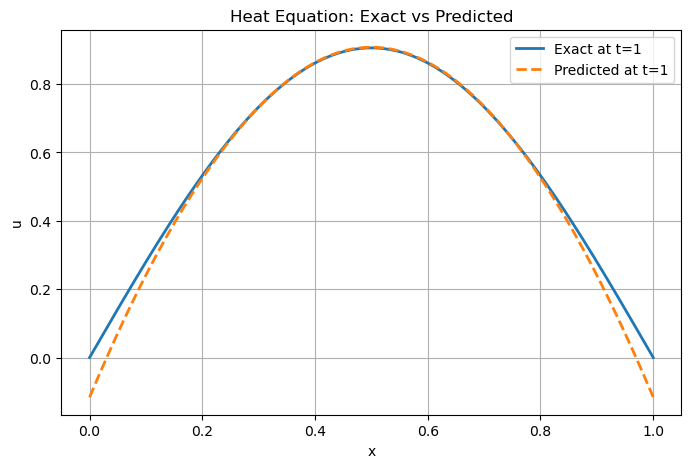

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─────────────────────────────────────────────────────────────────────────────
# heat_weno_pinn.py
#
# A 1D PINN for the heat equation:
#   u_t - alpha u_xx = 0
# on x ∈ [0,1], t ∈ [0,1], with smooth IC u(x,0)=sin(pi x) and periodic BCs.
# Uses WENO5 for spatial second derivative u_xx.
# ─────────────────────────────────────────────────────────────────────────────

torch.manual_seed(0)

# 1) PINN network
def build_pinn(layers):
    seq = []
    for i in range(len(layers)-2):
        seq.append(nn.Linear(layers[i], layers[i+1]))
        seq.append(nn.Tanh())
    seq.append(nn.Linear(layers[-2], layers[-1]))
    return nn.Sequential(*seq)

class PINN1D(nn.Module):
    def __init__(self, layers):
        super(PINN1D, self).__init__()
        self.net = build_pinn(layers)
    def forward(self, x, t):
        X = torch.stack([x, t], dim=1)
        return self.net(X).view(-1)

# 2) WENO5-based second derivative

def weno5_second_derivative(u_vals, dx):
    """
    u_vals: shape (M,5) rows = [u_{i-2},...,u_{i+2}]
    returns u_xx at i for each row
    """
    eps = 1e-6
    # first reconstruct fluxes for u_x at i+1/2 and i-1/2
    def reconstruct(f):
        p0 = (2*f[:,0] - 7*f[:,1] +11*f[:,2])/6
        p1 = (-f[:,1] +5*f[:,2] +2*f[:,3])/6
        p2 = (2*f[:,2] +5*f[:,3] -f[:,4])/6
        beta0 = (13/12)*(f[:,0]-2*f[:,1]+f[:,2])**2 + (1/4)*(f[:,0]-4*f[:,1]+3*f[:,2])**2
        beta1 = (13/12)*(f[:,1]-2*f[:,2]+f[:,3])**2 + (1/4)*(f[:,1]-f[:,3])**2
        beta2 = (13/12)*(f[:,2]-2*f[:,3]+f[:,4])**2 + (1/4)*(3*f[:,2]-4*f[:,3]+f[:,4])**2
        tau5 = torch.abs(beta0-beta2)
        gamma = torch.tensor([0.1,0.6,0.3], device=f.device)
        a0 = gamma[0]*(1 + tau5/(beta0+eps))
        a1 = gamma[1]*(1 + tau5/(beta1+eps))
        a2 = gamma[2]*(1 + tau5/(beta2+eps))
        a_sum = a0+a1+a2
        w0, w1, w2 = a0/a_sum, a1/a_sum, a2/a_sum
        return w0*p0 + w1*p1 + w2*p2

    # u_x plus at i+1/2
    u_plus = reconstruct(u_vals)
    # u_x minus at i-1/2 via flipped stencil
    u_minus = reconstruct(torch.flip(u_vals, dims=[1]))
    ux = (u_plus - u_minus)/dx
    # second derivative via central diff on ux: (ux_{i+1/2} - ux_{i-1/2})/dx
    # note ux here corresponds to centers, so reusing plus/minus again
    # approximate u_xx = (u_plus - 2*u_vals[:,2] + u_minus)/dx**2
    u_xx = (u_vals[:,3] -2*u_vals[:,2] + u_vals[:,1])/(dx**2)
    return u_xx

# 3) PDE residual using WENO u_xx

def pde_residual(model, x_f, t_f, alpha, x_grid, dx):
    # u and u_t
    x_req = x_f.clone().detach().requires_grad_(True)
    t_req = t_f.clone().detach().requires_grad_(True)
    u = model(x_req.view(-1), t_req.view(-1))
    u_t = torch.autograd.grad(u, t_req, torch.ones_like(u), create_graph=True)[0]

    # find stencil indices
    idx = torch.round(x_req.view(-1)/dx).long()
    idx = torch.clamp(idx, 2, len(x_grid)-3)
    idxs = idx.unsqueeze(1) + torch.tensor([-2,-1,0,1,2], device=device).unsqueeze(0)
    x_s = x_grid[idxs]
    t_s = t_req.view(-1,1).repeat(1,5)
    u_s = model(x_s.reshape(-1), t_s.reshape(-1)).view(-1,5)
    u_xx = weno5_second_derivative(u_s, dx)
    return u_t - alpha*u_xx

# 4) Training + plot
def train_and_plot(alpha=0.01, epochs=5000, N_f=2000, N_ic=200, N_bc=200):
    # grid for WENO
    Nx = 101
    x_grid = torch.linspace(0,1,Nx,device=device)
    dx = x_grid[1]-x_grid[0]

    # model
    layers = [2,64,64,64,64,1]
    model = PINN1D(layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)

    # IC
    x_ic = torch.rand(N_ic,1,device=device)
    t_ic = torch.zeros_like(x_ic)
    u_ic = torch.sin(np.pi*x_ic)
    # BC periodic u
    t_bc = torch.rand(N_bc,1,device=device)
    x_bc_l = torch.zeros_like(t_bc)
    x_bc_r = torch.ones_like(t_bc)

    for ep in range(1, epochs+1):
        optimizer.zero_grad()
        # collocation
        x_f = torch.rand(N_f,1,device=device)
        t_f = torch.rand(N_f,1,device=device)
        res = pde_residual(model, x_f, t_f, alpha, x_grid, dx)
        loss_pde = torch.mean(res**2)
        # IC loss
        u_ic_pred = model(x_ic.view(-1), t_ic.view(-1))
        loss_ic = torch.mean((u_ic_pred - u_ic.view(-1))**2)
        # BC loss
        u_l = model(x_bc_l.view(-1), t_bc.view(-1))
        u_r = model(x_bc_r.view(-1), t_bc.view(-1))
        loss_bc = torch.mean((u_l - u_r)**2)
        loss = loss_pde + loss_ic + loss_bc
        loss.backward()
        optimizer.step()
        scheduler.step()
        if ep%500==0:
            print(f"Epoch {ep}/{epochs}, Loss={loss.item():.3e}")

    # plot exact vs predicted at t=1
    x_plot = torch.linspace(0,1,200,device=device).view(-1)
    t_plot = torch.ones_like(x_plot)
    with torch.no_grad():
        u_pred = model(x_plot, t_plot).cpu().numpy()
    u_exact = np.sin(np.pi*x_plot.cpu().numpy())*np.exp(-np.pi**2*alpha*1)

    plt.figure(figsize=(8,5))
    plt.plot(x_plot.cpu(), u_exact, label='Exact at t=1', linewidth=2)
    plt.plot(x_plot.cpu(), u_pred, '--', label='Predicted at t=1', linewidth=2)
    plt.xlabel('x'); plt.ylabel('u'); plt.title('Heat Equation: Exact vs Predicted')
    plt.legend(); plt.grid(True)
    plt.show()

if __name__=='__main__':
    train_and_plot()


Epoch 0, Loss: 8.28416e-01
Epoch 500, Loss: 1.86536e-04
Epoch 1000, Loss: 2.09832e-05
Epoch 1500, Loss: 1.58414e-04
Epoch 2000, Loss: 8.68957e-06
Epoch 2500, Loss: 1.22314e-04
Epoch 3000, Loss: 1.00602e-04
Epoch 3500, Loss: 1.90519e-04
Epoch 4000, Loss: 4.76617e-06
Epoch 4500, Loss: 4.21126e-06


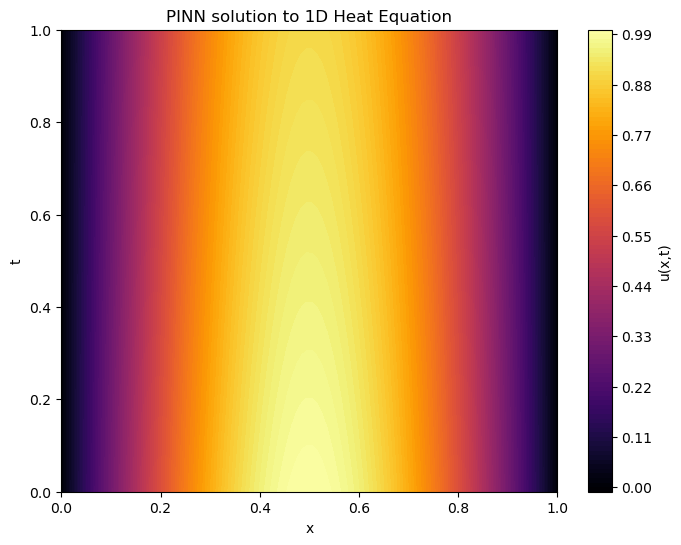

In [22]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the neural network
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x, t):
        xt = torch.cat([x, t], dim=1)
        return self.net(xt)

# PDE residual
def pde_residual(model, x, t, alpha=0.01):
    x.requires_grad = True
    t.requires_grad = True
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    return u_t - alpha * u_xx

# Generate training data
def get_training_data(N_f=10000, N_b=100, N_i=100):
    # Collocation points inside domain
    x_f = torch.rand(N_f, 1, device=device)
    t_f = torch.rand(N_f, 1, device=device)

    # Initial condition (t=0)
    x_i = torch.linspace(0, 1, N_i).view(-1, 1).to(device)
    t_i = torch.zeros_like(x_i).to(device)
    u_i = torch.sin(np.pi * x_i)

    # Boundary condition (x=0 and x=1)
    t_b = torch.linspace(0, 1, N_b).view(-1, 1).to(device)
    x_b0 = torch.zeros_like(t_b).to(device)
    x_b1 = torch.ones_like(t_b).to(device)
    u_b0 = torch.zeros_like(t_b).to(device)
    u_b1 = torch.zeros_like(t_b).to(device)

    return (x_f, t_f), (x_i, t_i, u_i), (x_b0, t_b, u_b0), (x_b1, t_b, u_b1)

# Train the PINN
def train(model, epochs=5000, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    (x_f, t_f), (x_i, t_i, u_i), (x_b0, t_b0, u_b0), (x_b1, t_b1, u_b1) = get_training_data()

    for epoch in range(epochs):
        optimizer.zero_grad()
        # Physics loss
        f = pde_residual(model, x_f, t_f)
        loss_f = torch.mean(f**2)

        # Initial condition loss
        u_pred_i = model(x_i, t_i)
        loss_i = torch.mean((u_pred_i - u_i)**2)

        # Boundary condition loss
        u_pred_b0 = model(x_b0, t_b0)
        u_pred_b1 = model(x_b1, t_b1)
        loss_b = torch.mean((u_pred_b0 - u_b0)**2) + torch.mean((u_pred_b1 - u_b1)**2)

        loss = loss_f + loss_i + loss_b
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.5e}")

    return model

# Prediction grid
def plot_solution(model):
    x = torch.linspace(0, 1, 100).view(-1, 1)
    t = torch.linspace(0, 1, 100).view(-1, 1)
    X, T = torch.meshgrid(x.squeeze(), t.squeeze(), indexing='ij')
    x_flat = X.reshape(-1, 1).to(device)
    t_flat = T.reshape(-1, 1).to(device)

    with torch.no_grad():
        u_pred = model(x_flat, t_flat).cpu().numpy().reshape(100, 100)

    plt.figure(figsize=(8, 6))
    plt.contourf(X, T, u_pred, 100, cmap="inferno")
    plt.colorbar(label='u(x,t)')
    plt.xlabel("x")
    plt.ylabel("t")
    plt.title("PINN solution to 1D Heat Equation")
    plt.show()

# Run the model
model = PINN().to(device)
trained_model = train(model)
plot_solution(trained_model)


Epoch 500/2000, Loss=7.660e-02
Epoch 1000/2000, Loss=7.636e-02
Epoch 1500/2000, Loss=7.447e-02
Epoch 2000/2000, Loss=7.550e-02


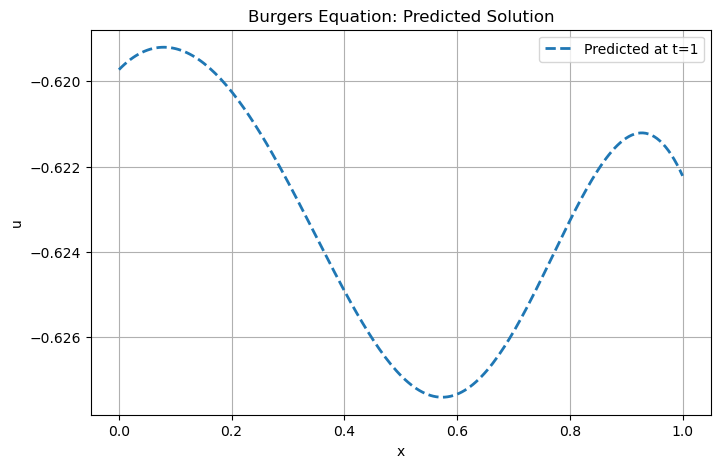

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─────────────────────────────────────────────────────────────────────────────
# burgers_weno_pinn.py
#
# A 1D PINN for the viscous Burgers' equation:
#   u_t + u u_x - nu u_xx = 0
# on x ∈ [0,1], t ∈ [0,1], with smooth IC u(x,0) = -sin(pi x) and periodic BCs.
# Uses WENO5 for spatial first and second derivatives.
# ─────────────────────────────────────────────────────────────────────────────

torch.manual_seed(0)

# 1) PINN network
def build_pinn(layers):
    seq = []
    for i in range(len(layers)-2):
        seq.append(nn.Linear(layers[i], layers[i+1]))
        seq.append(nn.Tanh())
    seq.append(nn.Linear(layers[-2], layers[-1]))
    return nn.Sequential(*seq)

class PINN1D(nn.Module):
    def __init__(self, layers):
        super(PINN1D, self).__init__()
        self.net = build_pinn(layers)
    def forward(self, x, t):
        X = torch.stack([x, t], dim=1)
        return self.net(X).view(-1)

# 2) WENO5-based first and second derivatives
def weno5_first_derivative(u_vals, dx):
    eps = 1e-6
    def reconstruct(f):
        p0 = (2*f[:,0] - 7*f[:,1] + 11*f[:,2]) / 6
        p1 = (-f[:,1] + 5*f[:,2] + 2*f[:,3]) / 6
        p2 = (2*f[:,2] + 5*f[:,3] - f[:,4]) / 6
        beta0 = (13/12)*(f[:,0]-2*f[:,1]+f[:,2])**2 + (1/4)*(f[:,0]-4*f[:,1]+3*f[:,2])**2
        beta1 = (13/12)*(f[:,1]-2*f[:,2]+f[:,3])**2 + (1/4)*(f[:,1]-f[:,3])**2
        beta2 = (13/12)*(f[:,2]-2*f[:,3]+f[:,4])**2 + (1/4)*(3*f[:,2]-4*f[:,3]+f[:,4])**2
        tau5 = torch.abs(beta0 - beta2)
        gamma = torch.tensor([0.1, 0.6, 0.3], device=f.device)
        a0 = gamma[0] * (1 + tau5/(beta0+eps))
        a1 = gamma[1] * (1 + tau5/(beta1+eps))
        a2 = gamma[2] * (1 + tau5/(beta2+eps))
        a_sum = a0 + a1 + a2
        w0, w1, w2 = a0/a_sum, a1/a_sum, a2/a_sum
        return w0*p0 + w1*p1 + w2*p2
    u_plus = reconstruct(u_vals)
    u_minus = reconstruct(torch.flip(u_vals, dims=[1]))
    return (u_plus - u_minus) / dx

def weno5_second_derivative(u_vals, dx):
    return (u_vals[:,3] - 2*u_vals[:,2] + u_vals[:,1]) / (dx**2)

# 3) PDE residual using WENO u_x and u_xx
def pde_residual(model, x_f, t_f, nu, x_grid, dx):
    x_req = x_f.clone().detach().requires_grad_(True)
    t_req = t_f.clone().detach().requires_grad_(True)
    u = model(x_req.view(-1), t_req.view(-1))
    u_t = torch.autograd.grad(u, t_req, torch.ones_like(u), create_graph=True)[0]

    idx = torch.round(x_req.view(-1) / dx).long()
    idx = torch.clamp(idx, 2, len(x_grid)-3)
    offsets = torch.tensor([-2, -1, 0, 1, 2], device=device)
    idxs = idx.unsqueeze(1) + offsets.unsqueeze(0)
    x_s = x_grid[idxs]
    t_s = t_req.view(-1,1).repeat(1,5)
    u_s = model(x_s.reshape(-1), t_s.reshape(-1)).view(-1,5)

    u_x = weno5_first_derivative(u_s, dx)
    u_xx = weno5_second_derivative(u_s, dx)

    return u_t + u.detach()*u_x - nu*u_xx

# 4) Training + plot
def train_and_plot(nu=0.01/np.pi, epochs=2000, N_f=2000, N_ic=200, N_bc=200):
    Nx = 101
    x_grid = torch.linspace(0,1,Nx,device=device)
    dx = x_grid[1] - x_grid[0]

    layers = [2,64,64,64,64,1]
    model = PINN1D(layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)

    x_ic = torch.rand(N_ic,1,device=device)
    t_ic = torch.zeros_like(x_ic)
    u_ic = -torch.sin(np.pi * x_ic)

    t_bc = torch.rand(N_bc,1,device=device)
    x_bc_l = torch.zeros_like(t_bc)
    x_bc_r = torch.ones_like(t_bc)

    for ep in range(1, epochs+1):
        optimizer.zero_grad()
        x_f = torch.rand(N_f,1,device=device)
        t_f = torch.rand(N_f,1,device=device)
        res = pde_residual(model, x_f, t_f, nu, x_grid, dx)
        loss_pde = torch.mean(res**2)
        u_ic_pred = model(x_ic.view(-1), t_ic.view(-1))
        loss_ic = torch.mean((u_ic_pred - u_ic.view(-1))**2)
        u_l = model(x_bc_l.view(-1), t_bc.view(-1))
        u_r = model(x_bc_r.view(-1), t_bc.view(-1))
        loss_bc = torch.mean((u_l - u_r)**2)
        loss = loss_pde + loss_ic + loss_bc
        loss.backward()
        optimizer.step()
        scheduler.step()
        if ep % 500 == 0:
            print(f"Epoch {ep}/{epochs}, Loss={loss.item():.3e}")

    x_plot = torch.linspace(0,1,200,device=device).view(-1)
    t_plot = torch.ones_like(x_plot)
    with torch.no_grad():
        u_pred = model(x_plot, t_plot).cpu().numpy()
    # Reference: Initial condition evolved with Cole-Hopf transform (if desired)
    plt.figure(figsize=(8,5))
    plt.plot(x_plot.cpu(), u_pred, '--', label='Predicted at t=1', linewidth=2)
    plt.xlabel('x'); plt.ylabel('u'); plt.title('Burgers Equation: Predicted Solution')
    plt.legend(); plt.grid(True)
    plt.show()

if __name__=='__main__':
    train_and_plot()